# Assignment 2

Akos Engelmann, Simon Jasansky

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [5]:
# we don't need to load the y_train and y_test, as we will not use the labels of the image
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()

In [6]:
# split the test data into test and validation
data = np.concatenate((x_train, x_test))
print(data.shape)
# the shape is as expected, 60000 samples with 32x32 pictures, with 3 layers (RGB)

(60000, 32, 32, 3)


(32, 32, 3)
(32, 3)
(3,)
[59 62 63]


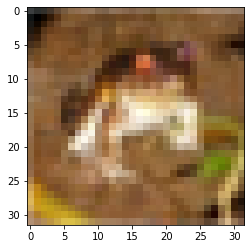

In [7]:
# first picture
print(data[0].shape)

# first row (or column, idk) of pixels of the picture
print(data[0][0].shape)

# first pixel of the first row/column of the picture (RGB values)
print(data[0][0][0].shape)
print(data[0][0][0])

# print the first picture
plt.imshow(data[0])
plt.show()

In [8]:
# do normalization over each image (use L2 norm)
data = data.astype("float32")
data = tf.keras.utils.normalize(data, axis = 1, order = 2)

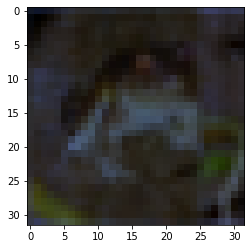

In [9]:
# print the first picture again (normalized)
plt.imshow(data[0])
plt.show()

In [11]:
# reshuffle before splitting data
np.random.shuffle(data)

# split into train, test and validation sets
train = data[:48000]
test = data[48000:54000]
valid = data[54000:]

print(train.shape)
print(test.shape)
print(valid.shape)

(48000, 32, 32, 3)
(6000, 32, 32, 3)
(6000, 32, 32, 3)


In [23]:
# implement CAE
input_layer = Input(shape=(32, 32, 3), name="INPUT")

x = Conv2D(filters = 8,
           kernel_size = (3, 3),
           strides = 1,
           activation='relu', padding='same')(input_layer)
x = MaxPooling2D(pool_size = (2, 2), strides = 1, padding = "same")(x)
x = Conv2D(filters = 8, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)

latent_space_rep = MaxPooling2D((2, 2), strides = 1, padding = "same", name = "LATENT_SPACE")(x)

x = UpSampling2D((2, 2))(latent_space_rep)
x = Conv2DTranspose(12, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [26]:
pic_CAE = Model(input_layer, output_layer)
pic_CAE.compile(optimizer='adam', loss='mse')
pic_CAE.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
LATENT_SPACE (MaxPooling2D)  (None, 32, 32, 8)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 12)       

In [29]:
# train the model
pic_CAE.fit(train, train,
           epochs=10,
           batch_size=128,
           shuffle=True,
           validation_data=(test, test))

Epoch 1/10


ValueError: in user code:

    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1195 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:10397 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:3477 _create_op_internal
        ret = Operation(
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\simi1\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 128 and 32 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](functional_1/OUTPUT/BiasAdd, IteratorGetNext:1)' with input shapes: [128,128,128,3], [128,32,32,3].
